In [74]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
from src.data import *

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import plot_confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [34]:
X, y = load_data()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

$Preproccesing data for XGBoost and LightGBM$

In [36]:
wp = WellProcessor()

In [37]:
wp.fit(X_train)
X_train = wp.transform(X_train)

In [38]:
X_test = wp.transform(X_test)

$XGBoost$

Becuase it is one of the strongest, if not the strongest, model on the market currently. I wanted to start with XGBoost to see what kind of results it can give as a benchmark.

In [39]:
# Instantiate XGBClassifier
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train, y_train)

# Predict on training and test sets
training_preds_xgb = XGB.predict(X_train)
test_preds_xgb = XGB.predict(X_test)

In [40]:
print(classification_report(y_test, test_preds_xgb))

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      4572
           1       0.64      0.25      0.36       851
           2       0.77      0.91      0.84      6457

    accuracy                           0.79     11880
   macro avg       0.75      0.63      0.66     11880
weighted avg       0.79      0.79      0.78     11880



While XGBoost gave great results with default hyperparameters, it took a minimum of 12minutes to run. I wanted to compare its results to more efficent models.

*$DecisionTreeClassifier$*

My next model was a Decision Tree. I wanted something to compare to XGBoost that was a little bit more simple, but still could deal with complex models. I also wanted a model that could execute faster than XGBoost.

In [4]:
rn_dtc = run_model (X_train, y_train, DecisionTreeClassifier())

0.7634231192054719


In [5]:
rn_dtc.best_score_

0.7634231192054719

We had a nice score from our Decision Tree Classifier, but not as high as our XGBoost.

$Random Forest Classifier$

While my Decision Tree Classifier gave good results I wanted to try a more complex Random Forest Classifier to compare it to. I had great success with Random Forest in previous work, so it seemed like a natural choice.

In [141]:
rn_rfc = run_model (X_train, y_train, RandomForestClassifier())

0.7823800122315898


In [142]:
rn_rfc.best_score_

0.7823800122315898

My Random Forest gave a better score than my Decision Tree, which was great but the improvement wasnt as large as I was hoping. It was also slower than my Decision Tree.

$Naive Bayes$

While the Random Forest was a success, I wanted to see if we can improve a scores by a greater margin. One of the biggest challnenges for our data is the dataset is so large. Naive Bayes models are recorded to be better with larger datasets, so I wanted to use one next.

In [9]:
rn_gnb = run_model (X_train, y_train, GaussianNB())

0.1799257700085921


In [10]:
rn_gnb.best_score_

0.1799257700085921

Huge drop in score, the dream has ended, hope is gone.

$LightGBM$

After a misreble attempt with a Naive Bayes model I did some research into how to make our current best model even better. LightGBM is reported to be as competitive as XGBoost but with much faster times.

In [43]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_train, y_train)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_train)
test_preds_lgbm = lgbm.predict(X_test)

In [44]:
print(classification_report(y_test, test_preds_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      4572
           1       0.65      0.23      0.34       851
           2       0.76      0.91      0.83      6457

    accuracy                           0.79     11880
   macro avg       0.75      0.62      0.65     11880
weighted avg       0.79      0.79      0.77     11880



$Hypertuning our Best Model$

I starterd Hyper tuning with a parameter grid using our class model. I picked several semi random parameters, and gave them ranges. A starting point.

In [52]:
param_grid = {
    'estimator__max_depth': [5,6,7,8],
    'estimator__min_samples_split': [500,1000,1500],
    'estimator__max_leaf_nodes': [10,25,50],
    'estimator__min_samples_leaf': [100, 250]
}

In [53]:
rn_rfc_bp = run_model (X_train, y_train, RandomForestClassifier(), param_grid=param_grid)

0.5196142021514092


In [55]:
rn_rfc_bp.best_params_

{'estimator__max_depth': 8,
 'estimator__max_leaf_nodes': 50,
 'estimator__min_samples_leaf': 100,
 'estimator__min_samples_split': 500}

The above method didn't work as well as I was hoping, and reduced our over score dramaticlly. As all the estimators are at the extremes of each range, I chose to go with another approach and use Validation Curves. Building the curve and plotting it will help show me the direction and slope of the score- basicly a hot or cold meter .

n_estimators

In [127]:
param_range = [300, 500, 750, 800, 1200] #500 best

In [128]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(max_depth=30, class_weight="balanced"),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

In [131]:
test_scoreNum #800 best

array([[0.79185606, 0.79848485, 0.79482323],
       [0.79248737, 0.79772727, 0.79520202],
       [0.79179293, 0.79728535, 0.79501263],
       [0.79198232, 0.79753788, 0.7947601 ],
       [0.79248737, 0.79690657, 0.79583333]])

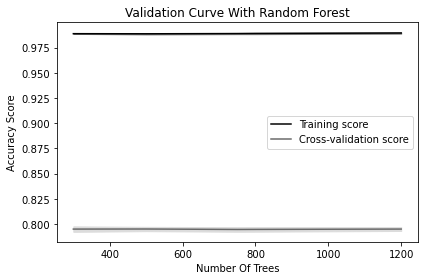

In [129]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

max_depth

In [154]:
#param_range=[5,10,15,20,25,30] #30 best maybe 40
param_range=[15,20,25,30, 35, 40]

In [155]:
train_scoreMD, test_scoreMD = validation_curve(
                                RandomForestClassifier(class_weight='balanced_subsample'),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = param_range, cv = 3)
print(train_scoreMD)
print(test_scoreMD)

[[0.80334596 0.79955808 0.7967803 ]
 [0.89756944 0.89662247 0.89659091]
 [0.95969066 0.96089015 0.96076389]
 [0.98784722 0.98683712 0.98734217]
 [0.99520202 0.99472854 0.99548611]
 [0.99703283 0.9969697  0.99709596]]
[[0.73667929 0.74166667 0.72853535]
 [0.77417929 0.7792298  0.77032828]
 [0.78731061 0.79602273 0.78977273]
 [0.79236111 0.79539141 0.79513889]
 [0.79349747 0.79602273 0.79526515]
 [0.79349747 0.79690657 0.79513889]]


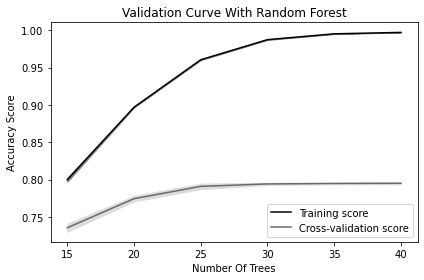

In [156]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreMD, axis=1)
train_std = np.std(train_scoreMD, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreMD, axis=1)
test_std = np.std(test_scoreMD, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

max_leaf_nodes

In [133]:
param_range=[1, 2, 4, 6, 8, 10] #2 is best

In [134]:
train_scoreMSS, test_scoreMSS = validation_curve(
                                RandomForestClassifier(max_depth=30, class_weight="balanced"),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = param_range, cv = 3)
print(train_scoreMSS)
print(test_scoreMSS)

[[       nan        nan        nan]
 [0.98712121 0.98661616 0.98809975]
 [0.94217172 0.94182449 0.94387626]
 [0.91268939 0.91224747 0.91442551]
 [0.89450758 0.89239268 0.89750631]
 [0.87979798 0.87787247 0.88188131]]
[[       nan        nan        nan]
 [0.79343434 0.79671717 0.79343434]
 [0.7885101  0.79147727 0.7875    ]
 [0.78194444 0.78680556 0.77960859]
 [0.77563131 0.78137626 0.77638889]
 [0.77361111 0.7790404  0.77013889]]


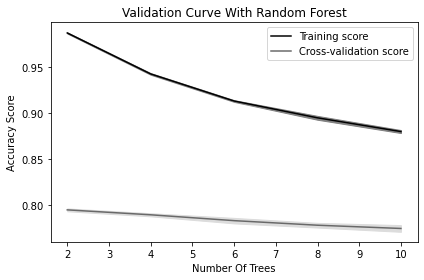

In [135]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreMSS, axis=1)
train_std = np.std(train_scoreMSS, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreMSS, axis=1)
test_std = np.std(test_scoreMSS, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [137]:
param_range=[1, 2, 5, 10, 15]

In [138]:
train_scoreMSL, test_scoreMSL = validation_curve(
                                RandomForestClassifier(max_depth=30, class_weight="balanced"),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = param_range, cv = 3)
print(train_scoreMSS)
print(test_scoreMSS)

[[       nan        nan        nan]
 [0.98712121 0.98661616 0.98809975]
 [0.94217172 0.94182449 0.94387626]
 [0.91268939 0.91224747 0.91442551]
 [0.89450758 0.89239268 0.89750631]
 [0.87979798 0.87787247 0.88188131]]
[[       nan        nan        nan]
 [0.79343434 0.79671717 0.79343434]
 [0.7885101  0.79147727 0.7875    ]
 [0.78194444 0.78680556 0.77960859]
 [0.77563131 0.78137626 0.77638889]
 [0.77361111 0.7790404  0.77013889]]


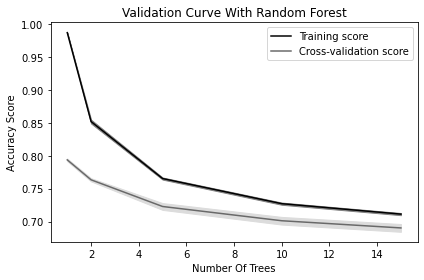

In [139]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreMSL, axis=1)
train_std = np.std(train_scoreMSL, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreMSL, axis=1)
test_std = np.std(test_scoreMSL, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [104]:
param_range = ['auto', 'sqrt', 'log2'] #auto is best

In [105]:
train_scoreMF, test_scoreMF = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_features', 
                                param_range = param_range, cv = 3)
print(train_scoreMF)
print(test_scoreMF)

[[0.99801136 0.99794823 0.9979798 ]
 [0.99794823 0.99794823 0.99801136]
 [0.99804293 0.9979798  0.99801136]]
[[0.79217172 0.79791667 0.79640152]
 [0.79084596 0.7967803  0.79627525]
 [0.78964646 0.79381313 0.79375   ]]


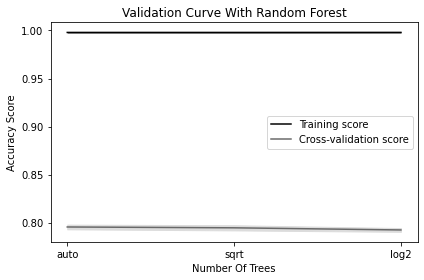

In [106]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreMF, axis=1)
train_std = np.std(train_scoreMF, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreMF, axis=1)
test_std = np.std(test_scoreMF, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [113]:
param_range = ['gini', 'entropy']

In [114]:
train_scoreC, test_scoreC = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'criterion', 
                                param_range = param_range, cv = 3)
print(train_scoreC)
print(test_scoreC)

[[0.99804293 0.99791667 0.99804293]
 [0.9979798  0.99791667 0.99801136]]
[[0.79305556 0.79684343 0.79520202]
 [0.79292929 0.7967803  0.79646465]]


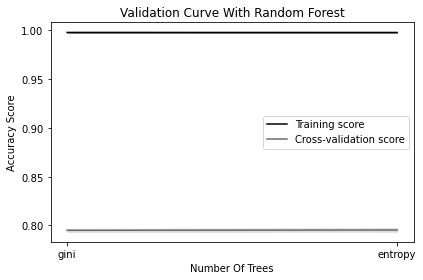

In [115]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreC, axis=1)
train_std = np.std(train_scoreC, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreC, axis=1)
test_std = np.std(test_scoreC, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [125]:
y_train.value_counts()

status_group
2               25802
0               18252
1                3466
dtype: int64

In [111]:
rn_bm = run_model (X_train, y_train, RandomForestClassifier(n_estimators=800, max_depth=30, min_samples_split=5))
rn_bm.best_score_

0.7545470822405571


Not a great score, it was reduced by .03% lets try dropping some parameters and balancing our data. Bellow I began plugging in some of the best performing hyper parameters together to see what the results are.

Our classes also are not balanced so lets try adding a class_weight.

In [136]:
rn_bm2 = run_model (X_train, y_train, RandomForestClassifier(n_estimators=500, max_depth=30, class_weight='balanced'))
rn_bm2.best_score_

0.7754218135020243


0.7754218135020243

In [140]:
rn_bm3 = run_model (X_train, y_train, RandomForestClassifier(n_estimators=1500, max_depth=30, class_weight='balanced'))
rn_bm3.best_score_

0.7751480660205685


0.7751480660205685

In [150]:
rn_bm4 = run_model (X_train, y_train, RandomForestClassifier(n_estimators=500, class_weight='balanced'))
rn_bm4.best_score_b    

0.7816679085857505


0.7816679085857505

In [146]:
rn_bm5 = run_model (X_train, y_train, RandomForestClassifier(class_weight='balanced'))
rn_bm5.best_score_

0.7822158687993156


0.7822158687993156

In [149]:
rn_bm6 = run_model (X_train, y_train, RandomForestClassifier(max_depth=20))
rn_bm6.best_score_

0.7029364520135222


0.7029364520135222

In [158]:
rn_bm7 = run_model (X_train, y_train, RandomForestClassifier(max_depth=40, class_weight='balanced_subsample'))
rn_bm7.best_score_

0.7799692784487643


0.7799692784487643

balanced supsample gave us an increase of .01

In [172]:
rn_bm8 = run_model (X_train, y_train, RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample'))
rn_bm8.best_score_

0.7819966607009526


0.7819966607009526

In [173]:
rn_bm9 = run_model (X_train, y_train, RandomForestClassifier(max_depth=30 ,n_estimators=500, class_weight='balanced_subsample'))
rn_bm9.best_score_

0.7743259981314934


0.7743259981314934

$BestModel$

Our best model appears to be a RandomForest Classifier with n_estimators=500, and class_weight balanced_subsample.

rn_bm8 = run_model (X_train, y_train, RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample'))

$Saving Y Preds$

Here we save the y predictors for both the train and test set, using our best model.

In [174]:
#train preds
y_pred_bm8 = rn_bm8.predict(X_train)

y_pred_tr = pd.DataFrame(data=y_pred_bm8, columns=y_train.columns, index=y_train.index)

y_pred_tr.to_csv('../data/best_y_preds.csv')

In [175]:
#test_preds
y_pred_test = rn_bm8.predict(X_test)

y_pred_testdf = pd.DataFrame(data=y_pred_test, columns=y_test.columns, index=y_test.index)

y_pred_testdf.to_csv('../data/y_preds_test.csv')